In [2]:
import pickle
import numpy as np
pickle_in = open("dataset_pickle\X_bot.pickle","rb")
X_bot = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\X_top.pickle","rb")
X_top = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_multimodal.pickle","rb")
labels = pickle.load(pickle_in)


# X_top = X_top/255.0
# X_bot = X_bot/255.0

print(X_top.shape)
print(X_bot.shape)

(1200, 100, 100, 1)
(1200, 100, 100, 1)


In [3]:
from sklearn.model_selection import train_test_split
x_train_comp = np.stack((X_top, X_bot), axis=4)
x_train, x_test, y_train, y_test1 = train_test_split(x_train_comp, labels, test_size = 0.3)

#print(x_train.shape)
#print(x_test.shape)

x_train_top = x_train[:,:,:,:,0]
x_test_top= x_test[:,:,:,:,0]

x_train_bot = x_train[:,:,:,:,1]
x_test_bot = x_test[:,:,:,:,1]

In [4]:
#Setup Distrbuited training
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())   #Enables

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from sklearn.model_selection import StratifiedKFold #for K-fold cross validation
import numpy
from keras.layers.merge import concatenate
import datetime

num_classes = 6

top_input = Input(X_top.shape[1:4])
bot_input = Input(X_bot.shape[1:4])

with strategy.scope():      #Enables multi-gpu
    # a layer instance is callable on a tensor, and returns a tensor
    top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top_input)
    top = MaxPooling2D(pool_size=(1, 5), strides=(4))(top)
    top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top)
    top = MaxPooling2D(pool_size=(1, 4), strides=(2))(top)
    top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top)
    top = MaxPooling2D(pool_size=(1, 2), strides=(2))(top)
    top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top)
    top = MaxPooling2D(pool_size=(2, 2), strides=(2))(top)
    top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top)
    top = MaxPooling2D(pool_size=(1, 2), strides=(2))(top)
    

    bot = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(bot_input)
    bot = MaxPooling2D(pool_size=(1, 5), strides=(4))(bot)
    bot = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(bot)
    bot = MaxPooling2D(pool_size=(1, 4), strides=(2))(bot)
    bot = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(bot)
    bot = MaxPooling2D(pool_size=(1, 2), strides=(2))(bot)
    bot = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(bot)
    bot = MaxPooling2D(pool_size=(2, 2), strides=(2))(bot)
    bot = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(bot)
    bot = MaxPooling2D(pool_size=(1, 2), strides=(2))(bot)


    z = concatenate([top, bot])
    z = Flatten()(z)
    y = Dense(6, activation='softmax')(z)

    lr_change = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.000)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='min')
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [lr_change,early_stopping,tensorboard_callback]

    model = Model(inputs=[top_input,bot_input], outputs=y)
    model.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.001),           
            metrics=['accuracy'])


model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)         

In [49]:
history = model.fit([x_train_top,x_train_bot], y_train, batch_size=16, epochs=100,callbacks=callbacks,
                    validation_data=([x_test_top,x_test_bot],y_test))

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = hierarchical_copy, num_packs = 1
53/53 [==============================] - 5s 61ms/step - loss: 7.4201 - accuracy: 0.1871 - val_loss: 1.4514 - val_accuracy: 0.3417
Epoch 2/100
53/53 [==============================] - 1s 20ms/step - loss: 1.3589 - accuracy: 0.4767 - val_loss: 1.0889 - val_accuracy: 0.5306
Epoch 3/100
53/53 [==============================] - 1s 23ms/step - loss: 1.0403 - accuracy: 0.5670 - val_loss: 0.8205 - val_accuracy: 0.6694
Epoch 4/100
53/53 [==============================] - 1s 24ms/step - loss: 0.8891 - accuracy: 0.6295 - val_loss: 0.7281 - val_accuracy: 0.6361
Epoch 5/100
53/53 [==============================] - 1s 24ms/step - loss: 0.6381 - accuracy: 0.7337 - val_loss: 0.5228 - val_accuracy: 0.8361
Epoch 6/100
53/53 [==============================] - 1s 24ms/step - loss: 0.7463 - accuracy:

38/38 - 1s - loss: 0.0663 - accuracy: 0.9875
38/38 [==============================] - 1s 11ms/step - loss: 0.0663 - accuracy: 0.9875


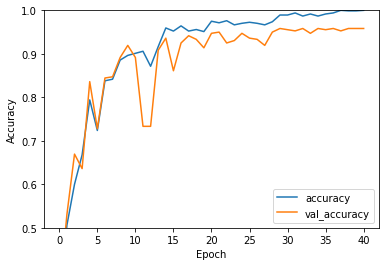

In [50]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate([X_top,X_bot], labels , verbose=2)
preds = model.evaluate([X_top,X_bot], labels,verbose=1, sample_weight=None)

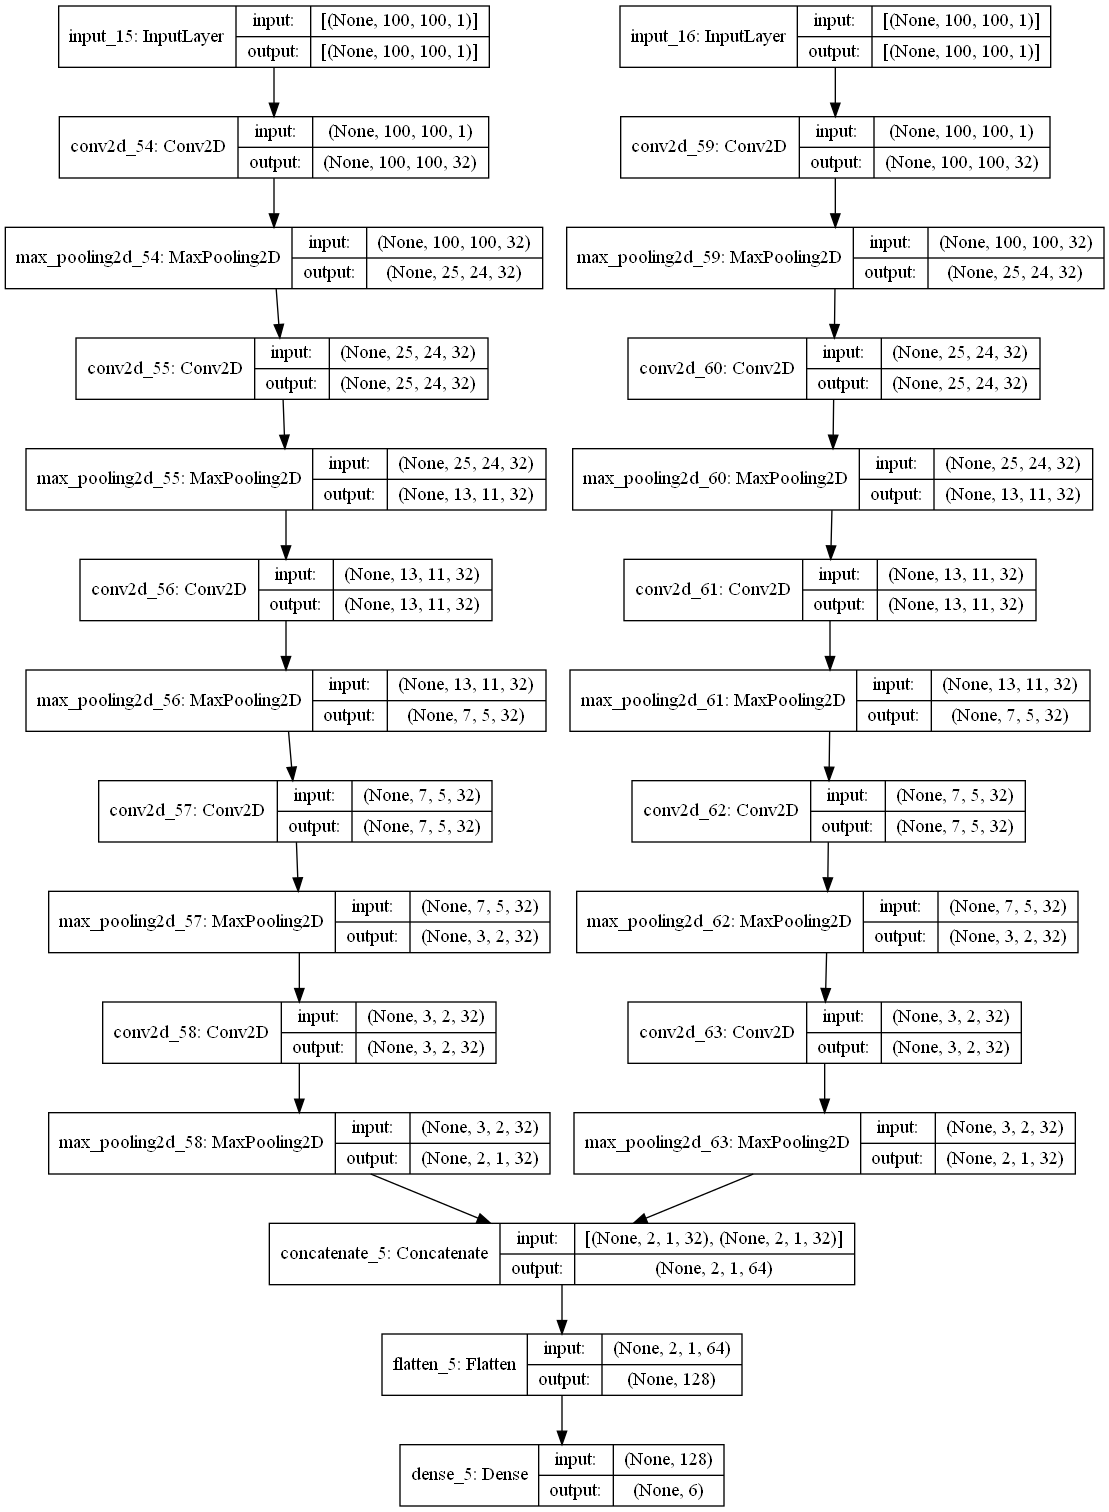

In [52]:
model.save("models\multimodal_habd3.h5")
print("model saved")

model saved


In [14]:
from keras.models import load_model
# load model
model = load_model('models\multimodal_habd2.h5')
# summarize model.
#model.summary()

In [15]:
# evaluate the model
import pickle
pickle_in = open("dataset_pickle\X_bot_user.pickle","rb")
X_test_bot = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\X_top_user.pickle","rb")
X_test_top = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_multimodal_user.pickle","rb")
y_test = pickle.load(pickle_in)

# X_test_bot = X_test_bot/255.0
# X_test_top = X_test_top/255.0

score = model.evaluate([X_test_top,X_test_bot], y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

8/8 - 0s - loss: 0.9112 - accuracy: 0.7542
accuracy: 75.42%


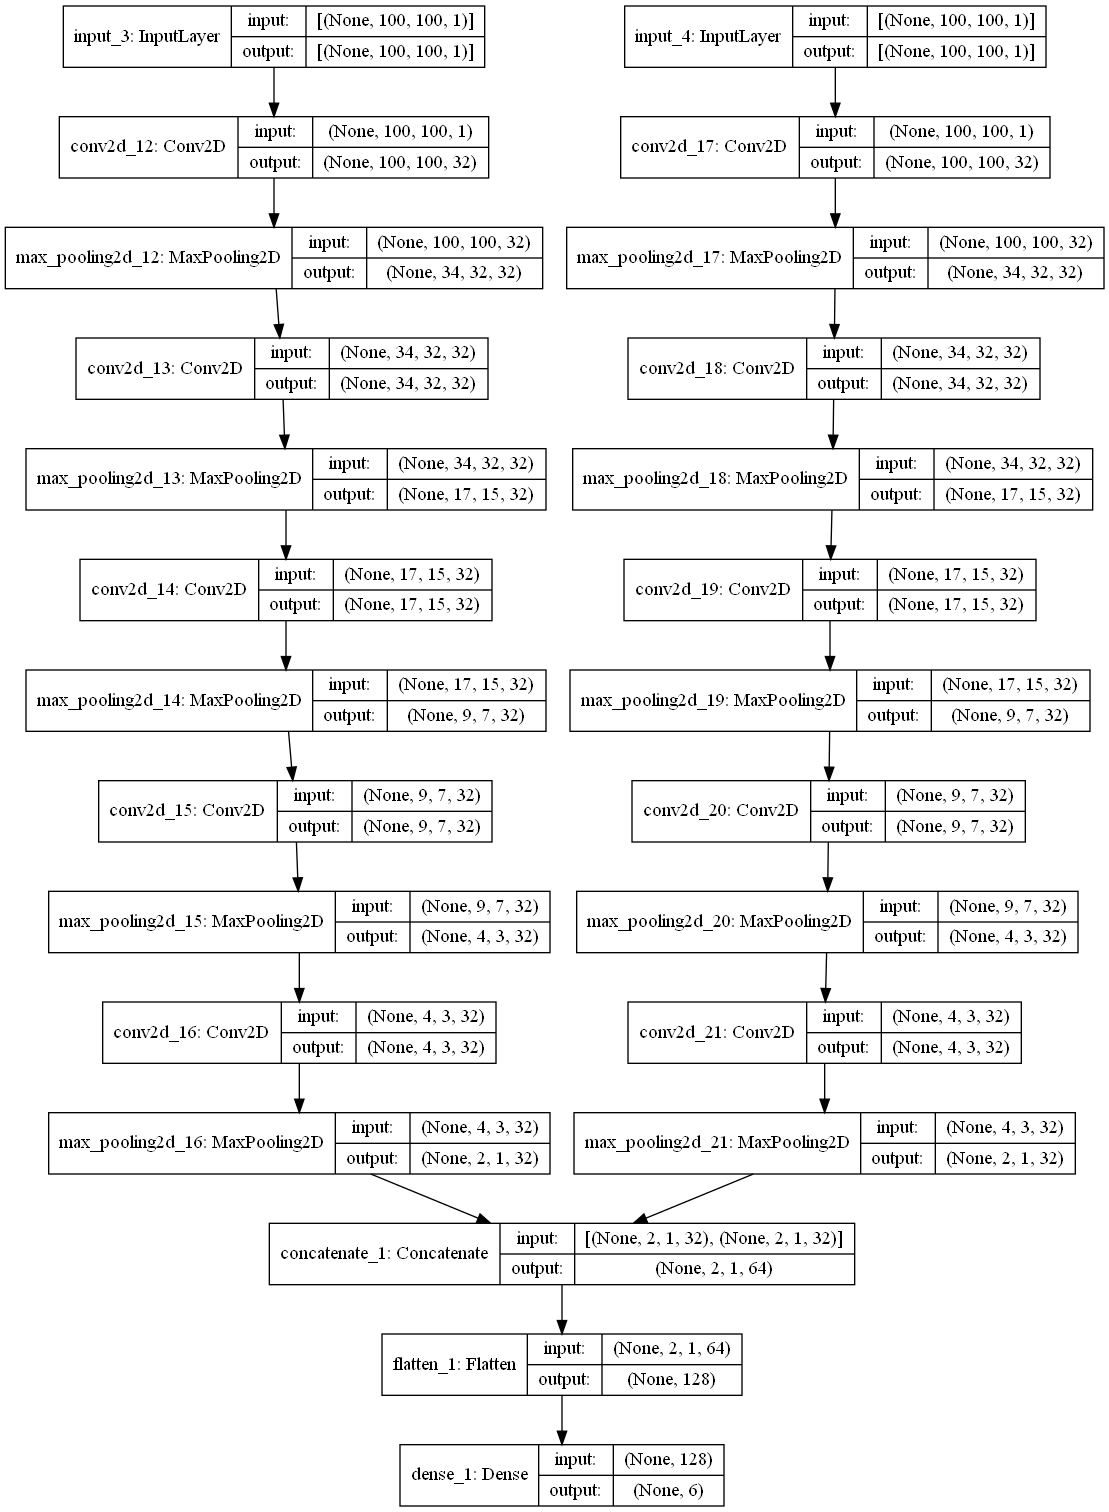

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [80]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
y_pred = model.predict([x_test_top,x_test_bot])
rounded_labels=np.argmax(y_pred, axis=1)
#print(rounded_labels)
confusion = confusion_matrix(y_test1, rounded_labels)

In [81]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[59  1  0  0  0  0]
 [ 0 52  0  0  0  0]
 [ 0  0 60  0  0  0]
 [ 0  0  0 67  0  0]
 [ 0  1  0  0 63  0]
 [ 0  1  0  0  1 55]]


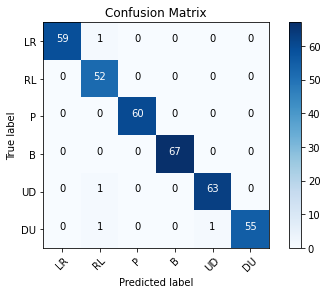

In [82]:
import itertools
Classes = ["LR", "RL", "P", "B", "UD", "DU"]
matrix = plot_confusion_matrix(cm=confusion,title='Confusion Matrix', classes=Classes)